<a href="https://colab.research.google.com/github/walson6/Stock-Price-Prediction-with-GRU/blob/main/Jim_GitHub_Stock_Prices_Forecasting_With_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###   Project Title: Stock Price Prediction with GRU Models

**Objective:**
To predict stock prices for companies in the CAC40 index using time series forecasting with Gated Recurrent Unit (GRU) models.

**Implementation:**
1. **Data Preparation:**
   - Collected historical stock price data for CAC40 companies (including open, close, high, low, and volume).
   - Preprocessed the data by cleaning and normalizing the stock prices to ensure consistency and facilitate model training.
   - Split the data into training and test sets, with 80% for training and 20% for testing.
   - Scaled the stock price features using MinMaxScaler to bring them into a range of [0, 1].
2. **Model Training and Evaluation:**
   - GRU Model:
       - Architecture: A GRU layer followed by a dense layer to predict the future stock price.
       - Trained for 50 epochs with a batch size of 64.
       - Achieved a Root Mean Squared Error (RMSE) of 3.45.
       - Observations: The GRU model provided a slightly less accurate prediction than LSTM but was computationally more efficient.

3. **Model Evaluation:**
   - Evaluated each model using RMSE and Mean Absolute Percentage Error (MAPE) to assess prediction accuracy.
   - Visualized the predicted stock prices versus actual prices using Matplotlib, showing how well the models tracked market trends.

**Skills Demonstrated:**
   - Proficiency in Python and TensorFlow/Keras for time series forecasting.
   - Knowledge of GRU architectures and their application in stock price prediction.
   - Experience with data preprocessing techniques such as normalization and splitting.
   - Evaluation of model performance using metrics like RMSE and MAPE.
   - Visualization skills for presenting model results and comparing predicted vs. actual outcomes.

**Tools and Libraries Used:**
   - Python
   - TensorFlow
   - Keras
   - pandas
   - NumPy
   - Matplotlib

In [ ]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Conv1D, Flatten, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
# Load csv file
files.upload_file('preprocessed_CAC40.csv')
df = pd.read_csv('preprocessed_CAC40.csv', parse_dates=['Date'])
print(df["Name"].unique())

Saved preprocessed_CAC40.csv to /content/preprocessed_CAC40.csv
['Accor' 'Air Liquide' 'Airbus ' 'ArcelorMittal' 'Atos' 'AXA'
 'BNP Paribas' 'Bouygues' 'Cap Gemini' 'Crédit Agricole' 'Danone'
 'Dassault Systèmes' 'Engie (ex GDF Suez' 'EssilorLuxottica'
 'Hermès (Hermes International' 'Kering' 'LEGRAND' 'LOréal'
 'LVMH Moet Hennessy Louis Vuitton'
 'Michelin (Compagnie Générale d Etablissements Michelin SCPA' 'Orange'
 'Pernod Ricard' 'Peugeot' 'Publicis' 'Renault' 'SAFRAN' 'Saint-Gobain'
 'Sanofi' 'Schneider Electric' 'Société Générale (Societe Generale'
 'Sodexo' 'STMicroelectronics' 'TOTAL' 'Unibail-Rodamco'
 'Veolia Environnement' 'VINCI' 'Vivendi' 'Worldline SA']


In [ ]:
def load_data(company, start, end):
    """
    Load data for the specified company and date range.
    :param company: The company's stock symbol (str)
    :param start: The starting date for the data range (str or datetime)
    :param end: The ending date for the data range (str or datetime)
    :return: A dataframe containing the relevant stock data (pandas.DataFrame)
    """
    dataframe = df.copy()
    dataframe = dataframe.loc[dataframe.Name == company, :]
    dataframe = dataframe.loc[(dataframe['Date'] > start) & (dataframe['Date'] < end), :]
    dataframe = dataframe.rename(columns = {'Closing_Price': 'Close'})
    return dataframe


In [ ]:
COMPANY = 'Atos' # Change based on what company you want to predict
START_DATE = dt.datetime(2015,1,1)
END_DATE = dt.datetime(2020,1,1)

START_DATE_TEST = END_DATE

In [ ]:
data = load_data(company = COMPANY,
                 start = START_DATE,
                 end = END_DATE)
data.head()

,Unnamed: 0,Name,Date,Open,Close,Daily_High,Daily_Low,Volume
10467,10467,Atos,2019-12-30,73.20,74.98,74.98,73.20,214
10468,10468,Atos,2019-12-27,75.76,76.00,76.00,75.76,NaN
10469,10469,Atos,2019-12-23,75.24,75.20,75.94,75.20,215
10470,10470,Atos,2019-12-20,75.72,75.42,76.12,75.42,164
10471,10471,Atos,2019-12-19,75.72,75.86,75.90,75.50,586


In [ ]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [ ]:
# Set the number of days used for prediction
prediction_days = 3

# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(scaled_data)):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(scaled_data[x - prediction_days:x, 0])
    # Append the current value to y_train
    y_train.append(scaled_data[x, 0])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the GRU model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
def GRU_model():
    """
    Create and configure an GRU model for stock price prediction.

    :return: The configured GRU model (keras.Sequential)
    """

    # Initialize a sequential model
    model = Sequential()

    # First GRU layer with increased units
    model.add(Bidirectional(GRU(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1))))
    model.add(Dropout(0.3))  # Slightly increased dropout for regularization

    # Second GRU layer
    model.add(GRU(units=64, return_sequences=True))
    model.add(Dropout(0.2))

    # Third GRU layer
    model.add(GRU(units=32))
    model.add(Dropout(0.2))

    # Dense output layer
    model.add(Dense(units=1))

    return model

def GRU_model2():
    # Build and train single layer GRU model
    model = Sequential()
    model.add(GRU(units=64, input_shape=(x_train.shape[1], 1)))
    model.add(Dense(units=1))
    return model


In [ ]:
# Training the model

model = GRU_model()
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_26 (GRU)                         │ (None, 64)                  │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size = 32
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1039
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1466e-04
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1892e-04
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0134e-04
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7246e-04
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7405e-04
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5675e-04
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3773e-04
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.9595e-04
Epoch 12/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3906e-04
Epoch 13/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3425e-04
Epoch 14/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1170e-04
Epoch 15/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s

In [ ]:
# Load test data for the specified company and date range
TEST_COMPANY = COMPANY
test_data = load_data(company=TEST_COMPANY,
    start=START_DATE_TEST,
    end=dt.datetime.now()
)

# Extract the actual closing prices from the test data
actual_prices = test_data['Close'].values

# Concatenate the training and test data along the 'Close' column
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

# Reshape the model inputs to a 2D array with a single column
model_inputs = model_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
model_inputs = scaler.transform(model_inputs)

In [ ]:
# Initialize an empty list for test data input
x_test = []
# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])
# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the GRU model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate price predictions using the GRU model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


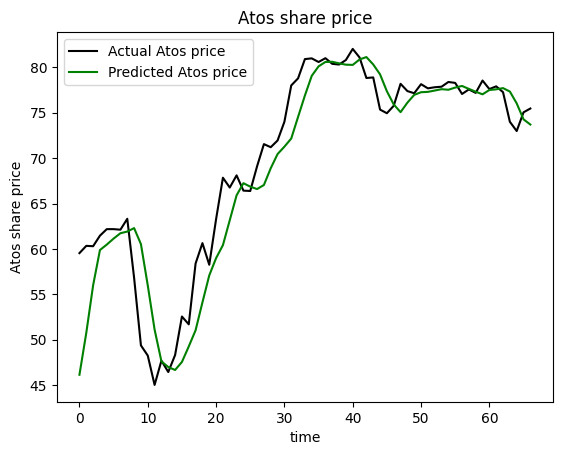

In [ ]:
# Plot the actual prices using a black line
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='green', label=f"Predicted {COMPANY} price")

# Set the title of the plot using the company name
plt.title(f"{COMPANY} share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"{COMPANY} share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

In [ ]:
# Extract the last 'prediction_days' values from the model inputs
#real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]
real_data = model_inputs[-prediction_days:]


# Convert the real_data list to a numpy array
real_data = np.array(real_data)

# Reshape real_data to a 3D array with the appropriate dimensions for the GRU model
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# Generate a prediction using the GRU model with the real_data input
prediction = model.predict(real_data)

# Invert the scaling applied to the prediction to obtain the actual value
prediction = scaler.inverse_transform(prediction)

# Print the prediction result to the console
print(f"Prediction: {prediction[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Prediction: 55.289649963378906
